In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import xgboost 
from sklearn import set_config
set_config(transform_output="pandas")
pd.set_option('display.max_columns', 500)



In [2]:
from db.database_mysql import engine

df = pd.read_sql_query('''SELECT jp.raw_title, 
        YEAR(jp.date) AS year, 
        MONTH(jp.date) AS month, 
        DAY(jp.date) AS day, 
        im.director, im.date,im.casting, im.distributor, im.genre, jp.country, jp.duration, jp.first_day, jp.first_week, jp.first_weekend, jp.hebdo_rank, 
jp.total_spectator, jp.copies, im.rating_press, im.budget, im.lang, im.award 
FROM films_jp as jp
LEFT JOIN films_imdb im ON im.id_jp = jp.id 
where im.id_jp is not null and im.date = jp.date
order by jp.first_week desc''', engine)

df

,raw_title,year,month,day,director,date,casting,distributor,genre,country,duration,first_day,first_week,first_weekend,hebdo_rank,total_spectator,copies,rating_press,budget,lang,award
0,Bienvenue chez les Ch'tis,2008,2,27,"""dany boon""",2008-02-27,"[""kad merad"", ""dany boon"", ""zoe felix""]","[""pathe renn productions"", ""hirsch"", ""les prod...","[""comedie"", ""romantique""]",france,6360,558359,4378720,3586497,1,20489303,793,7.1,11000000,"[""francais""]",5
1,Les Bronzés 3: Amis pour la vie,2006,2,1,"""patrice leconte""",2006-02-01,"[""josiane balasko"", ""michel blanc"", ""marieanne...","[""les films christian fechner"", ""tf1 films pro...","[""comedie""]",france,5820,537882,3906694,3235559,1,10355930,950,-1.0,35000000,"[""anglais"", ""italien"", ""francais""]",1
2,Taxi 2,2000,3,29,"""gerard krawczyk""",2000-03-29,"[""samy naceri"", ""frederic diefenthal"", ""emma w...","[""arp selection"", ""canal"", ""leeloo productions""]","[""action"", ""comedie"", ""policier""]",france,5400,801922,3478850,2951255,1,10345901,831,6.5,70000000,"[""francais"", ""japonais"", ""allemand""]",1
3,La Revanche des Sith,2005,5,18,"""george lucas""",2005-05-18,"[""hayden christensen"", ""natalie portman"", ""ewa...","[""lucasfilm"", ""mestiere cinema"", ""pandora films""]","[""action"", ""aventure"", ""fantastique""]",etatsunis,8760,641799,3303005,2878764,1,7247809,938,7.6,113000000,"[""anglais""]",29
4,Le Roi Lion (2019),2019,7,17,"""jon favreau""",2019-07-17,"[""donald glover"", ""beyonce"", ""seth rogen""]","[""walt disney pictures"", ""fairview entertainme...","[""animation"", ""aventure"", ""drame""]",etatsunis,7080,630478,3252896,2559370,1,10017995,680,6.8,260000000,"[""anglais"", ""espagnol""]",21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,Simon Werner a disparu,2010,9,22,"""fabrice gobert""",2010-09-22,"[""jules pelissier"", ""ana girardot"", ""audrey ba...","[""247 films"", ""canal"", ""cinecinema""]",None,france,5580,6351,48033,40282,15,79945,93,6.4,-1,"[""francais""]",3
2668,Innocents The Dreamers,2003,12,10,"""bernardo bertolucci""",2003-12-10,"[""michael pitt"", ""louis garrel"", ""eva green""]","[""recorded picture company rpc"", ""fiction"", ""p...",None,france,6960,7577,47922,-1,13,79849,-1,7.1,15000000,"[""anglais"", ""francais""]",2
2669,La Grande Bellezza,2013,5,22,"""paolo sorrentino""",2013-05-22,"[""toni servillo"", ""carlo verdone"", ""sabrina fe...","[""indigo film"", ""medusa film"", ""babe film""]","[""drame""]",italie,8460,4654,47900,36844,13,198373,81,7.7,9200000,"[""italien"", ""japonais"", ""espagnol"", ""chinois""]",60
2670,Un baiser papillon,2011,6,1,"""karine silla""",2011-06-01,"[""valeria golino"", ""elsa zylberstein"", ""vincen...","[""europacorp"", ""grive productions"", ""france 2 ...",None,france,6060,-1,47715,38189,14,47715,170,5.4,3500000,"[""francais""]",2


In [3]:
# data_path = "Dataset_analyse.csv"
# df = pd.read_csv(data_path)

# # df = df.drop(['month','month_name','director_combined_score','budget','entree_annee','raw_title','actor_list','rating_press','day',"",'distributor','classification_country','country',"hebdo_rank","first_day","first_weekend","casting","award","lang"], axis=1)
# df = df.drop(['director_combined_score','year_combined_score','distributor_combined_score','entree_annee','total_actor_scores','classification_country','country_combined_score','season','month_name','is_holiday','actor_list'], axis=1)
# df = df.dropna()

# df

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


from modelisation.functions import classify_entrees_year

entree_transformer = FunctionTransformer(classify_entrees_year, kw_args={'column' : 'year'})
entree_pip = make_pipeline(entree_transformer)
entree_ct = Pipeline([('entree_dict' , entree_pip)])

# entree_pipeline = make_pipeline(entree_ct)

entree_ct.fit_transform(df)

,raw_title,year,month,day,director,date,casting,distributor,genre,country,duration,first_day,first_week,first_weekend,hebdo_rank,total_spectator,copies,rating_press,budget,lang,award,entree_annee
0,Bienvenue chez les Ch'tis,2008,2,27,"""dany boon""",2008-02-27,"[""kad merad"", ""dany boon"", ""zoe felix""]","[""pathe renn productions"", ""hirsch"", ""les prod...","[""comedie"", ""romantique""]",france,6360,558359,4378720,3586497,1,20489303,793,7.1,11000000,"[""francais""]",5,190.3
1,Les Bronzés 3: Amis pour la vie,2006,2,1,"""patrice leconte""",2006-02-01,"[""josiane balasko"", ""michel blanc"", ""marieanne...","[""les films christian fechner"", ""tf1 films pro...","[""comedie""]",france,5820,537882,3906694,3235559,1,10355930,950,-1.0,35000000,"[""anglais"", ""italien"", ""francais""]",1,188.8
2,Taxi 2,2000,3,29,"""gerard krawczyk""",2000-03-29,"[""samy naceri"", ""frederic diefenthal"", ""emma w...","[""arp selection"", ""canal"", ""leeloo productions""]","[""action"", ""comedie"", ""policier""]",france,5400,801922,3478850,2951255,1,10345901,831,6.5,70000000,"[""francais"", ""japonais"", ""allemand""]",1,165.8
3,La Revanche des Sith,2005,5,18,"""george lucas""",2005-05-18,"[""hayden christensen"", ""natalie portman"", ""ewa...","[""lucasfilm"", ""mestiere cinema"", ""pandora films""]","[""action"", ""aventure"", ""fantastique""]",etatsunis,8760,641799,3303005,2878764,1,7247809,938,7.6,113000000,"[""anglais""]",29,175.6
4,Le Roi Lion (2019),2019,7,17,"""jon favreau""",2019-07-17,"[""donald glover"", ""beyonce"", ""seth rogen""]","[""walt disney pictures"", ""fairview entertainme...","[""animation"", ""aventure"", ""drame""]",etatsunis,7080,630478,3252896,2559370,1,10017995,680,6.8,260000000,"[""anglais"", ""espagnol""]",21,213.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,Simon Werner a disparu,2010,9,22,"""fabrice gobert""",2010-09-22,"[""jules pelissier"", ""ana girardot"", ""audrey ba...","[""247 films"", ""canal"", ""cinecinema""]",None,france,5580,6351,48033,40282,15,79945,93,6.4,-1,"[""francais""]",3,207.1
2668,Innocents The Dreamers,2003,12,10,"""bernardo bertolucci""",2003-12-10,"[""michael pitt"", ""louis garrel"", ""eva green""]","[""recorded picture company rpc"", ""fiction"", ""p...",None,france,6960,7577,47922,-1,13,79849,-1,7.1,15000000,"[""anglais"", ""francais""]",2,173.5
2669,La Grande Bellezza,2013,5,22,"""paolo sorrentino""",2013-05-22,"[""toni servillo"", ""carlo verdone"", ""sabrina fe...","[""indigo film"", ""medusa film"", ""babe film""]","[""drame""]",italie,8460,4654,47900,36844,13,198373,81,7.7,9200000,"[""italien"", ""japonais"", ""espagnol"", ""chinois""]",60,193.7
2670,Un baiser papillon,2011,6,1,"""karine silla""",2011-06-01,"[""valeria golino"", ""elsa zylberstein"", ""vincen...","[""europacorp"", ""grive productions"", ""france 2 ...",None,france,6060,-1,47715,38189,14,47715,170,5.4,3500000,"[""francais""]",2,217.2


In [5]:
from modelisation.functions import calculate_director_scores

director_transformer = FunctionTransformer(calculate_director_scores)
director_pip = make_pipeline(director_transformer)
director_ct = Pipeline([('director_dict' , director_pip)])


df = director_ct.fit_transform(df)

In [6]:
from modelisation.functions import calculate_distributor_scores

distributor_transformer = FunctionTransformer(calculate_distributor_scores)
distributor_pip = make_pipeline(distributor_transformer)
distributor_ct = Pipeline([('distributor_dict' , distributor_pip)])


df = distributor_ct.fit_transform(df)

In [7]:
from modelisation.functions import calculate_year_scores

year_transformer = FunctionTransformer(calculate_year_scores)
year_pip = make_pipeline(year_transformer)
year_ct = Pipeline([('year_dict' , year_pip)])


df = year_ct.fit_transform(df)

In [8]:
from modelisation.functions import calculate_country_scores

country_transformer = FunctionTransformer(calculate_country_scores)
country_pip = make_pipeline(country_transformer)
country_ct = Pipeline([('country_dict' , country_pip)])


df = country_ct.fit_transform(df)

In [9]:
from modelisation.functions import split_date

date_transformer = FunctionTransformer(split_date)
date_pip = make_pipeline(date_transformer)
date_ct = Pipeline([('date_dict' , date_pip)])


df = date_ct.fit_transform(df)

In [10]:
from modelisation.functions import classify_season

season_transformer = FunctionTransformer(classify_season,  kw_args={'column' : 'month'})
season_pip = make_pipeline(season_transformer)
season_ct = Pipeline([('season_dict' , season_pip)])


df = season_ct.fit_transform(df)

In [11]:
from modelisation.functions import classify_month_name

month_transformer = FunctionTransformer(classify_month_name,  kw_args={'column' : 'month'})
month_pip = make_pipeline(month_transformer)
month_ct = Pipeline([('month_dict' , month_pip)])


df = month_ct.fit_transform(df)

In [12]:
from modelisation.functions import is_holiday

holiday_transformer = FunctionTransformer(is_holiday)
holiday_pip = make_pipeline(holiday_transformer)
holiday_ct = Pipeline([('holiday_dict' , holiday_pip)])


df = holiday_ct.fit_transform(df)

In [13]:
# on drop les features inutiles
df = df.drop(["casting",'director','raw_title','distributor',"award","lang"], axis=1)
df

,year,month,day,genre,country,duration,first_day,first_week,first_weekend,hebdo_rank,total_spectator,copies,rating_press,budget,entree_annee,director_combined_score,distributor_combined_score,year_combined_score,country_combined_score,season,month_name,is_holiday
0,2008,2,27,"[""comedie"", ""romantique""]",france,6360,558359,4378720,3586497,1,20489303,793,7.1,11000000,190.3,0.474160,0.553998,0.847850,0.718999,winter,february,0
1,2006,2,1,"[""comedie""]",france,5820,537882,3906694,3235559,1,10355930,950,-1.0,35000000,188.8,0.251281,0.341859,0.872062,0.718999,winter,february,0
2,2000,3,29,"[""action"", ""comedie"", ""policier""]",france,5400,801922,3478850,2951255,1,10345901,831,6.5,70000000,165.8,0.393059,0.443038,0.776540,0.718999,spring,march,0
3,2005,5,18,"[""action"", ""aventure"", ""fantastique""]",etatsunis,8760,641799,3303005,2878764,1,7247809,938,7.6,113000000,175.6,0.517310,0.444225,0.832416,0.918252,spring,may,0
4,2019,7,17,"[""animation"", ""aventure"", ""drame""]",etatsunis,7080,630478,3252896,2559370,1,10017995,680,6.8,260000000,213.2,0.315627,0.446294,0.841668,0.918252,summer,july,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,2010,9,22,None,france,5580,6351,48033,40282,15,79945,93,6.4,-1,207.1,0.114926,0.048078,0.777537,0.718999,autumn,september,0
2668,2003,12,10,None,france,6960,7577,47922,-1,13,79849,-1,7.1,15000000,173.5,0.145297,0.137288,0.759540,0.718999,winter,december,0
2669,2013,5,22,"[""drame""]",italie,8460,4654,47900,36844,13,198373,81,7.7,9200000,193.7,0.186346,0.171417,0.831473,0.341090,spring,may,0
2670,2011,6,1,None,france,6060,-1,47715,38189,14,47715,170,5.4,3500000,217.2,0.115617,0.110159,0.899457,0.718999,summer,june,0


In [14]:
X = df.drop(['first_week'], axis=1)
y = df.first_week

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42)

num_col = list(X.select_dtypes(include=[float,int]).columns)
cat_col = list(X.select_dtypes(include=[object]).columns)

onehotscale_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore', sparse_output=False), RobustScaler(with_centering=False))
scale_pipeline = make_pipeline(RobustScaler(with_centering=False))

preprocessing = ColumnTransformer(
    transformers=[
        ('categorical', onehotscale_pipeline, cat_col),
        ('numerical', scale_pipeline, num_col)]
)

polyscale_pipeline = make_pipeline(PolynomialFeatures(2))

my_final_pipeline = make_pipeline(preprocessing)#, polyscale_pipeline)
my_final_pipeline.fit(X_train)

feature_names = my_final_pipeline.get_feature_names_out(X.columns)

In [15]:
# from sklearn import set_config


# set_config(transform_output="pandas")
# model = make_pipeline(
#     my_final_pipeline,
# )
# xdata = model.fit_transform(X_train, y_train)
# xdata.head()

In [16]:
model = make_pipeline(
    my_final_pipeline,
    xgboost.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    )

model.fit(X_train, y_train)

ValueError: feature_names must be string, and may not contain [, ] or <

In [ ]:
# pyplot.bar(range(len(model[-1].feature_importances_)), model[-1].feature_importances_)
# pyplot.show()

In [ ]:
xtrain_tr = model[:-1].fit_transform(X_train)

In [ ]:
xtrain_tr.columns

Index(['categorical__genre_action', 'categorical__genre_animation',
       'categorical__genre_aventure', 'categorical__genre_biographique',
       'categorical__genre_comedie', 'categorical__genre_documentaire',
       'categorical__genre_drame', 'categorical__genre_famille',
       'categorical__genre_fantastique', 'categorical__genre_horreur',
       'categorical__genre_mystere', 'categorical__genre_policier',
       'categorical__genre_romantique', 'categorical__genre_sciencefiction',
       'categorical__genre_thriller', 'categorical__country_afrique du sud',
       'categorical__country_allemagne', 'categorical__country_argentine',
       'categorical__country_australie', 'categorical__country_autriche',
       'categorical__country_belgique', 'categorical__country_bresil',
       'categorical__country_canada', 'categorical__country_chine',
       'categorical__country_coree du sud', 'categorical__country_danemark',
       'categorical__country_espagne', 'categorical__country_eta

In [ ]:
# pd.Series(model[-1].feature_importances_, index = xtrain_tr.columns)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

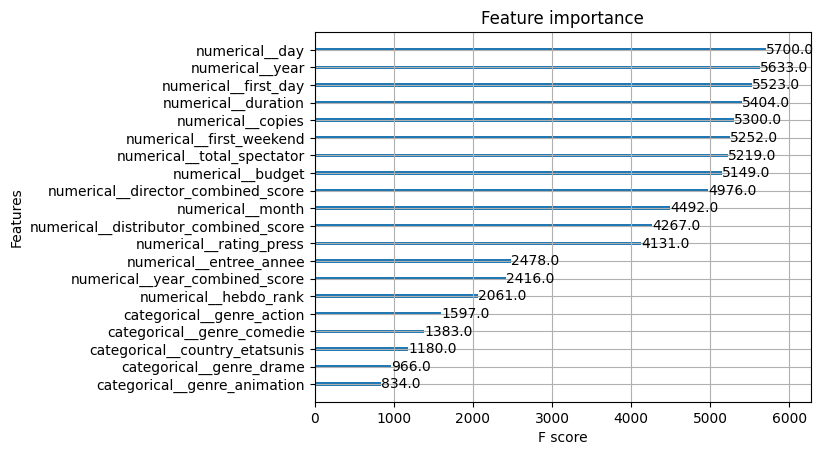

In [ ]:
xgboost.plot_importance(model[-1], max_num_features=20)

In [ ]:
# y_pred_train = model.predict(X_train)


# residus =  y_pred_train - y_train


# weights = np.exp(-abs(residus) / residus.std())
# model.fit(X_train, y_train, lasso__sample_weight=weights)




y_pred = model.predict(X_test)
# y_pred = model.predict(df_test)
# print(y_pred)

In [ ]:

r2_cleaned = r2_score(y_test, y_pred)
mse_cleaned = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse_cleaned = np.sqrt(mse_cleaned)

print("Performance du modèle :")
# print(model.best_params_)
print(f"R2 Score: {r2_cleaned:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse_cleaned:.2f}")

Performance du modèle :
R2 Score: 0.9795
MAE: 28820.00
RMSE: 52345.71


In [ ]:
from joblib import dump, load

model_path = 'model.pkl'
dump(model, model_path)
model = load('model.pkl')

In [ ]:
def predict_prod(model,data):
    # Convertir la liste de listes en DataFrame
    df = pd.DataFrame(data, columns=['year','season', 'entree_annee','is_holiday','month','day','director', 'country','classification_country','classification_acteurs' ,'duration', 'genre', 'copies', 'rating_press','budget','distributor'])
    predictions = model.predict(df)
    return predictions

predict_prod(model,[[2024,'spring', 180.8,1,3, 8,2, "etatsunis",3,3, 5640, "animation", 696, 3.4, 85000000, 3]])

ValueError: columns are missing: {'year_combined_score', 'first_weekend', 'total_spectator', 'hebdo_rank', 'director_combined_score', 'country_combined_score', 'first_day', 'distributor_combined_score'}